In [26]:
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import numpy as np
from numpy.random import seed, randint

In [27]:
seed(504)
tf.random.set_seed(504)

# Getting the data

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data.reshape(-1, 28, 28, 1), tf.keras.utils.to_categorical(mnist.target)
X_train, y_train = X[:60_000], y[:60_000]
X_test, y_test = X[60_000:], y[60_000:]

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


# Training the neural network

In [29]:
X.shape

(70000, 28, 28, 1)

In [30]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

cnn = tf.keras.models.Sequential([
    layers.Conv2D(16, 3, activation='relu', padding='same', input_shape=X_train[0].shape),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.SpatialDropout2D(.4),
    layers.AveragePooling2D(),
    layers.Conv2D(120, 3, activation='relu', padding='same'),
    layers.SpatialDropout2D(.4),
    layers.Flatten(),
    layers.Dense(units=84, activation='relu'),
    layers.Dropout(.4),
    layers.Dense(units=10, activation='softmax')
])

cnn.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 spatial_dropout2d_3 (Spatia  (None, 28, 28, 16)       0         
 lDropout2D)                                                     
                                                                 
 average_pooling2d_2 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 spatial_dropout2d_4 (Spatia  (None, 14, 14, 32)       0         
 lDropout2D)                                                     
                                                      

In [31]:
history = cnn.fit(X_train, y_train, 
                    epochs = 100, 
                    validation_split = 0.2,
                    callbacks=[es])

Epoch 1/100


2023-10-28 09:51:28.631776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/spatial_dropout2d_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1500/1500 [==============================] - 9s 4ms/step - loss: 2.3753 - accuracy: 0.2884 - val_loss: 1.1584 - val_accuracy: 0.6801
Epoch 2/100
1500/1500 [==============================] - 7s 4ms/step - loss: 1.3270 - accuracy: 0.5453 - val_loss: 0.5628 - val_accuracy: 0.8612
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.8277 - accuracy: 0.7299 - val_loss: 0.2562 - val_accuracy: 0.9388
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.5449 - accuracy: 0.8297 - val_loss: 0.1654 - val_accuracy: 0.9557
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4033 - accuracy: 0.8779 - val_loss: 0.1221 - val_accuracy: 0.9652
Epoch 6/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3162 - accuracy: 0.9058 - val_loss: 0.0947 - val_accuracy: 0.9739
Epoch 7/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2571 - accuracy: 0.9244 - val_loss: 0.0806 - val_accuracy: 0.97

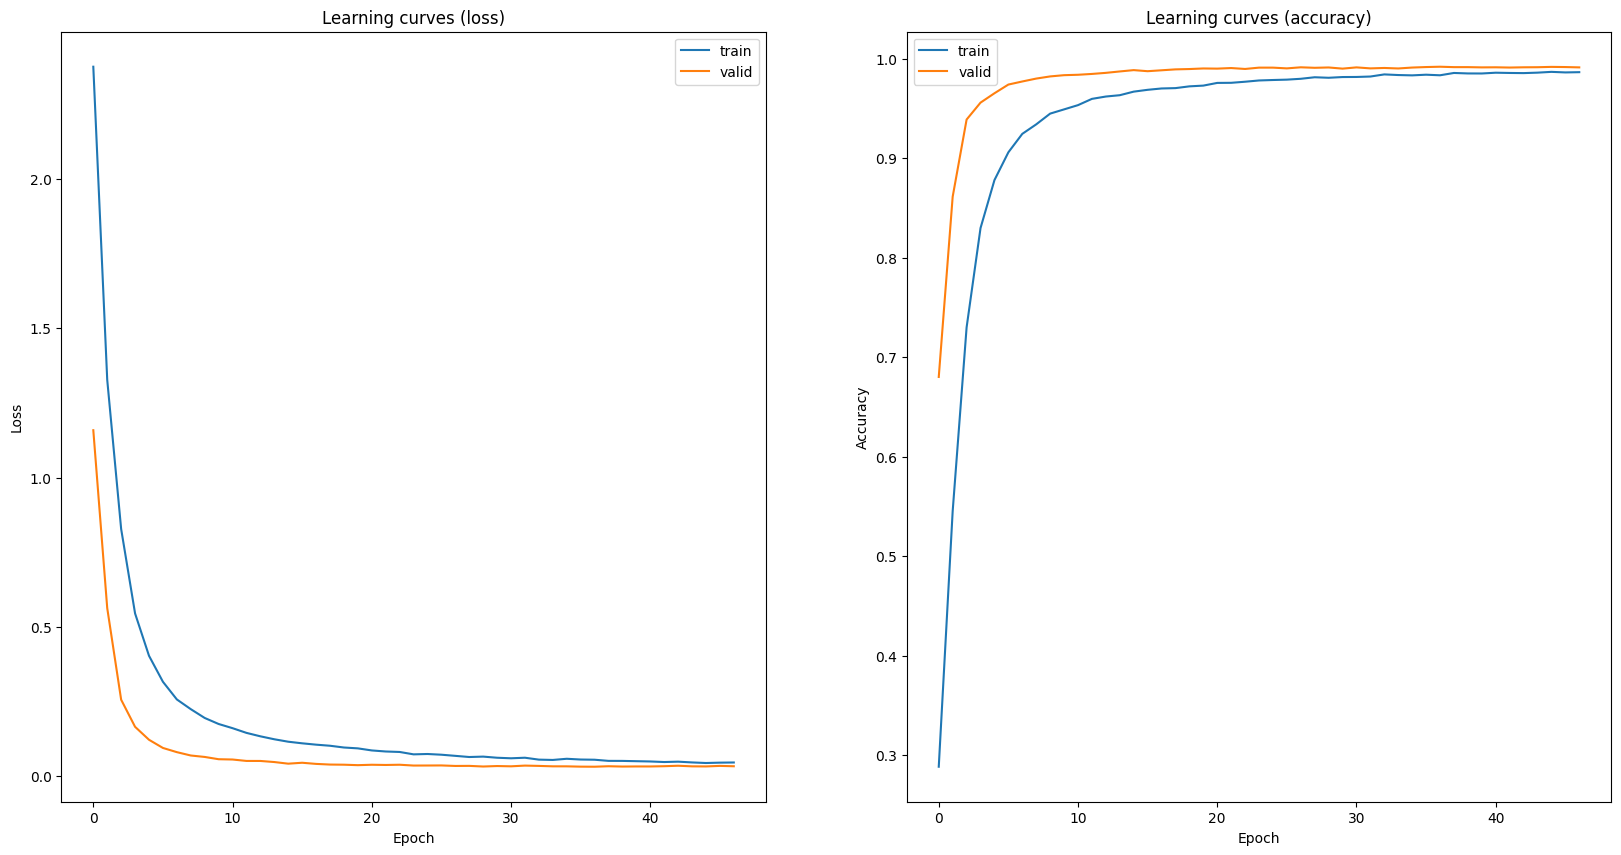

In [32]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'], label = 'train')
ax.plot(history.history['val_loss'], label = 'valid')
ax.legend()

ax = figure.add_subplot(1, 2, 2, title='Learning curves (accuracy)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'valid')
ax.legend()

plt.show()

In [33]:
train_eval = cnn.evaluate(X_train[:48000], y_train[:48000])
validation_eval = cnn.evaluate(X_train[48000:], y_train[48000:])
test_eval = cnn.evaluate(X_test, y_test)
print("On train data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=train_eval[0], accuracy=train_eval[1]))
print("On validation data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=validation_eval[0], accuracy=validation_eval[1]))
print("On test data: Loss = {loss:.4f}, accuracy = {accuracy:.4f}".format(loss=test_eval[0], accuracy=test_eval[1]))
print("Error on test data: {p:.2f}%".format(p = 100*(1-test_eval[1])))

313/313 [==============================] - 1s 3ms/step - loss: 0.0232 - accuracy: 0.9915
On train data: Loss = 0.0112, accuracy = 0.9971
On validation data: Loss = 0.0318, accuracy = 0.9918
On test data: Loss = 0.0232, accuracy = 0.9915
Error on test data: 0.85%


## Inspecting the kernels

Here are the kernels.

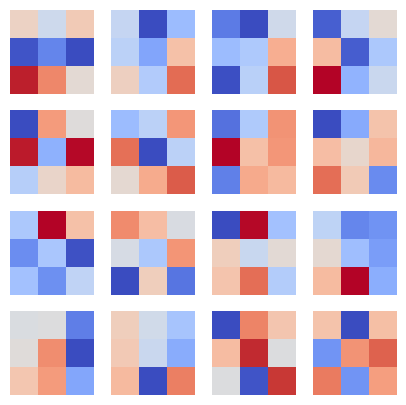

In [34]:
from matplotlib.colors import CenteredNorm

kernel_weights = cnn.layers[0].weights[0]
kernel_shape = kernel_weights.shape[:2]
kernels = [kernel_weights[:, :, :, i].numpy().reshape(kernel_shape) for i in range(kernel_weights.shape[-1])]

fig, axes = plt.subplots(4, 4, figsize=(5,5))
for index, kernel in enumerate(kernels):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(kernel, cmap='coolwarm', norm=CenteredNorm())


It's hard to get a handle on the kernels in themselves. Let's look at the feature map.

We'll use this 7 as an example.

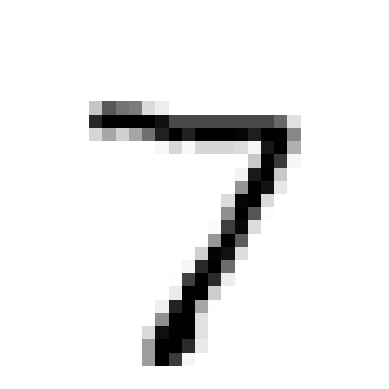

In [35]:
plt.axis('off')
plt.imshow(np.reshape(X_test[0], (28, 28)), cmap='Greys')

plt.show()

### Lowest convolutional layer

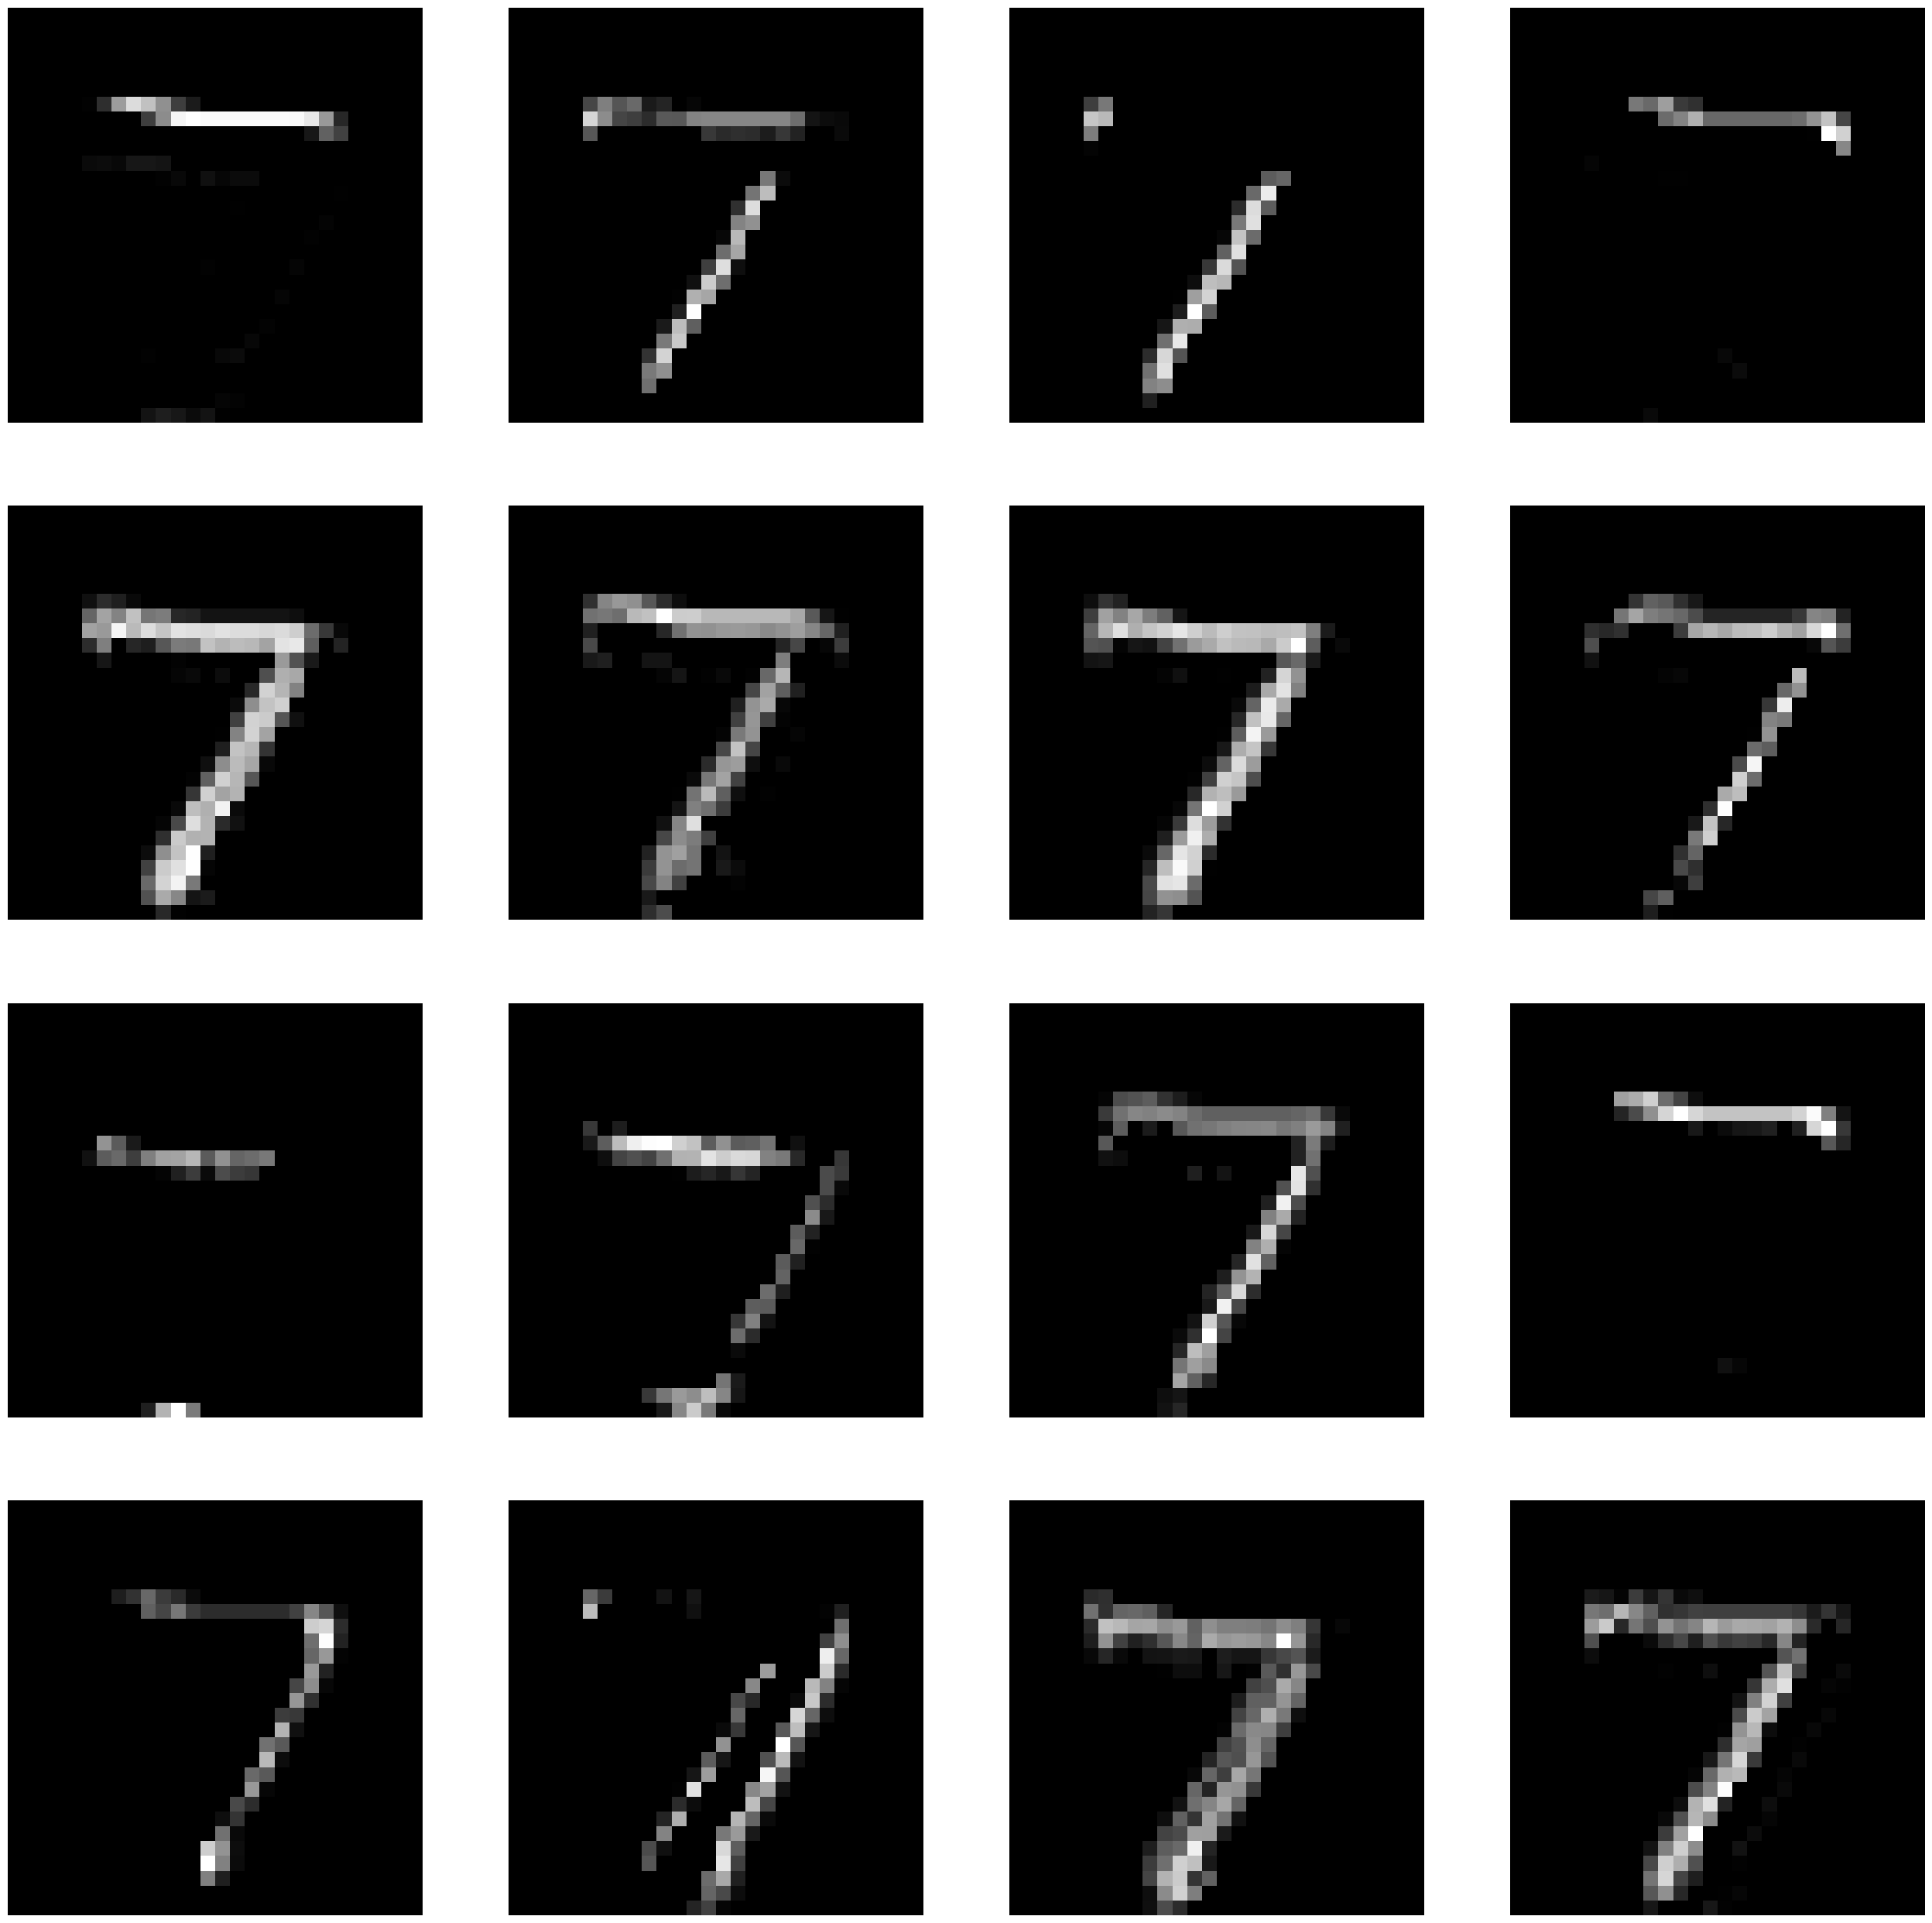

In [36]:
convolutional_layer = cnn.layers[0]
feature_maps = convolutional_layer(X_test[0:1])

fig, axes = plt.subplots(4, 4, figsize=(32,32))
for index in range(16):
    ax=axes[index // 4][index % 4]
    ax.axis('off')
    ax.imshow(feature_maps[0, :, :, index], cmap='gray')

### Middle convolutional layer

1/1 [==============================] - 0s 50ms/step


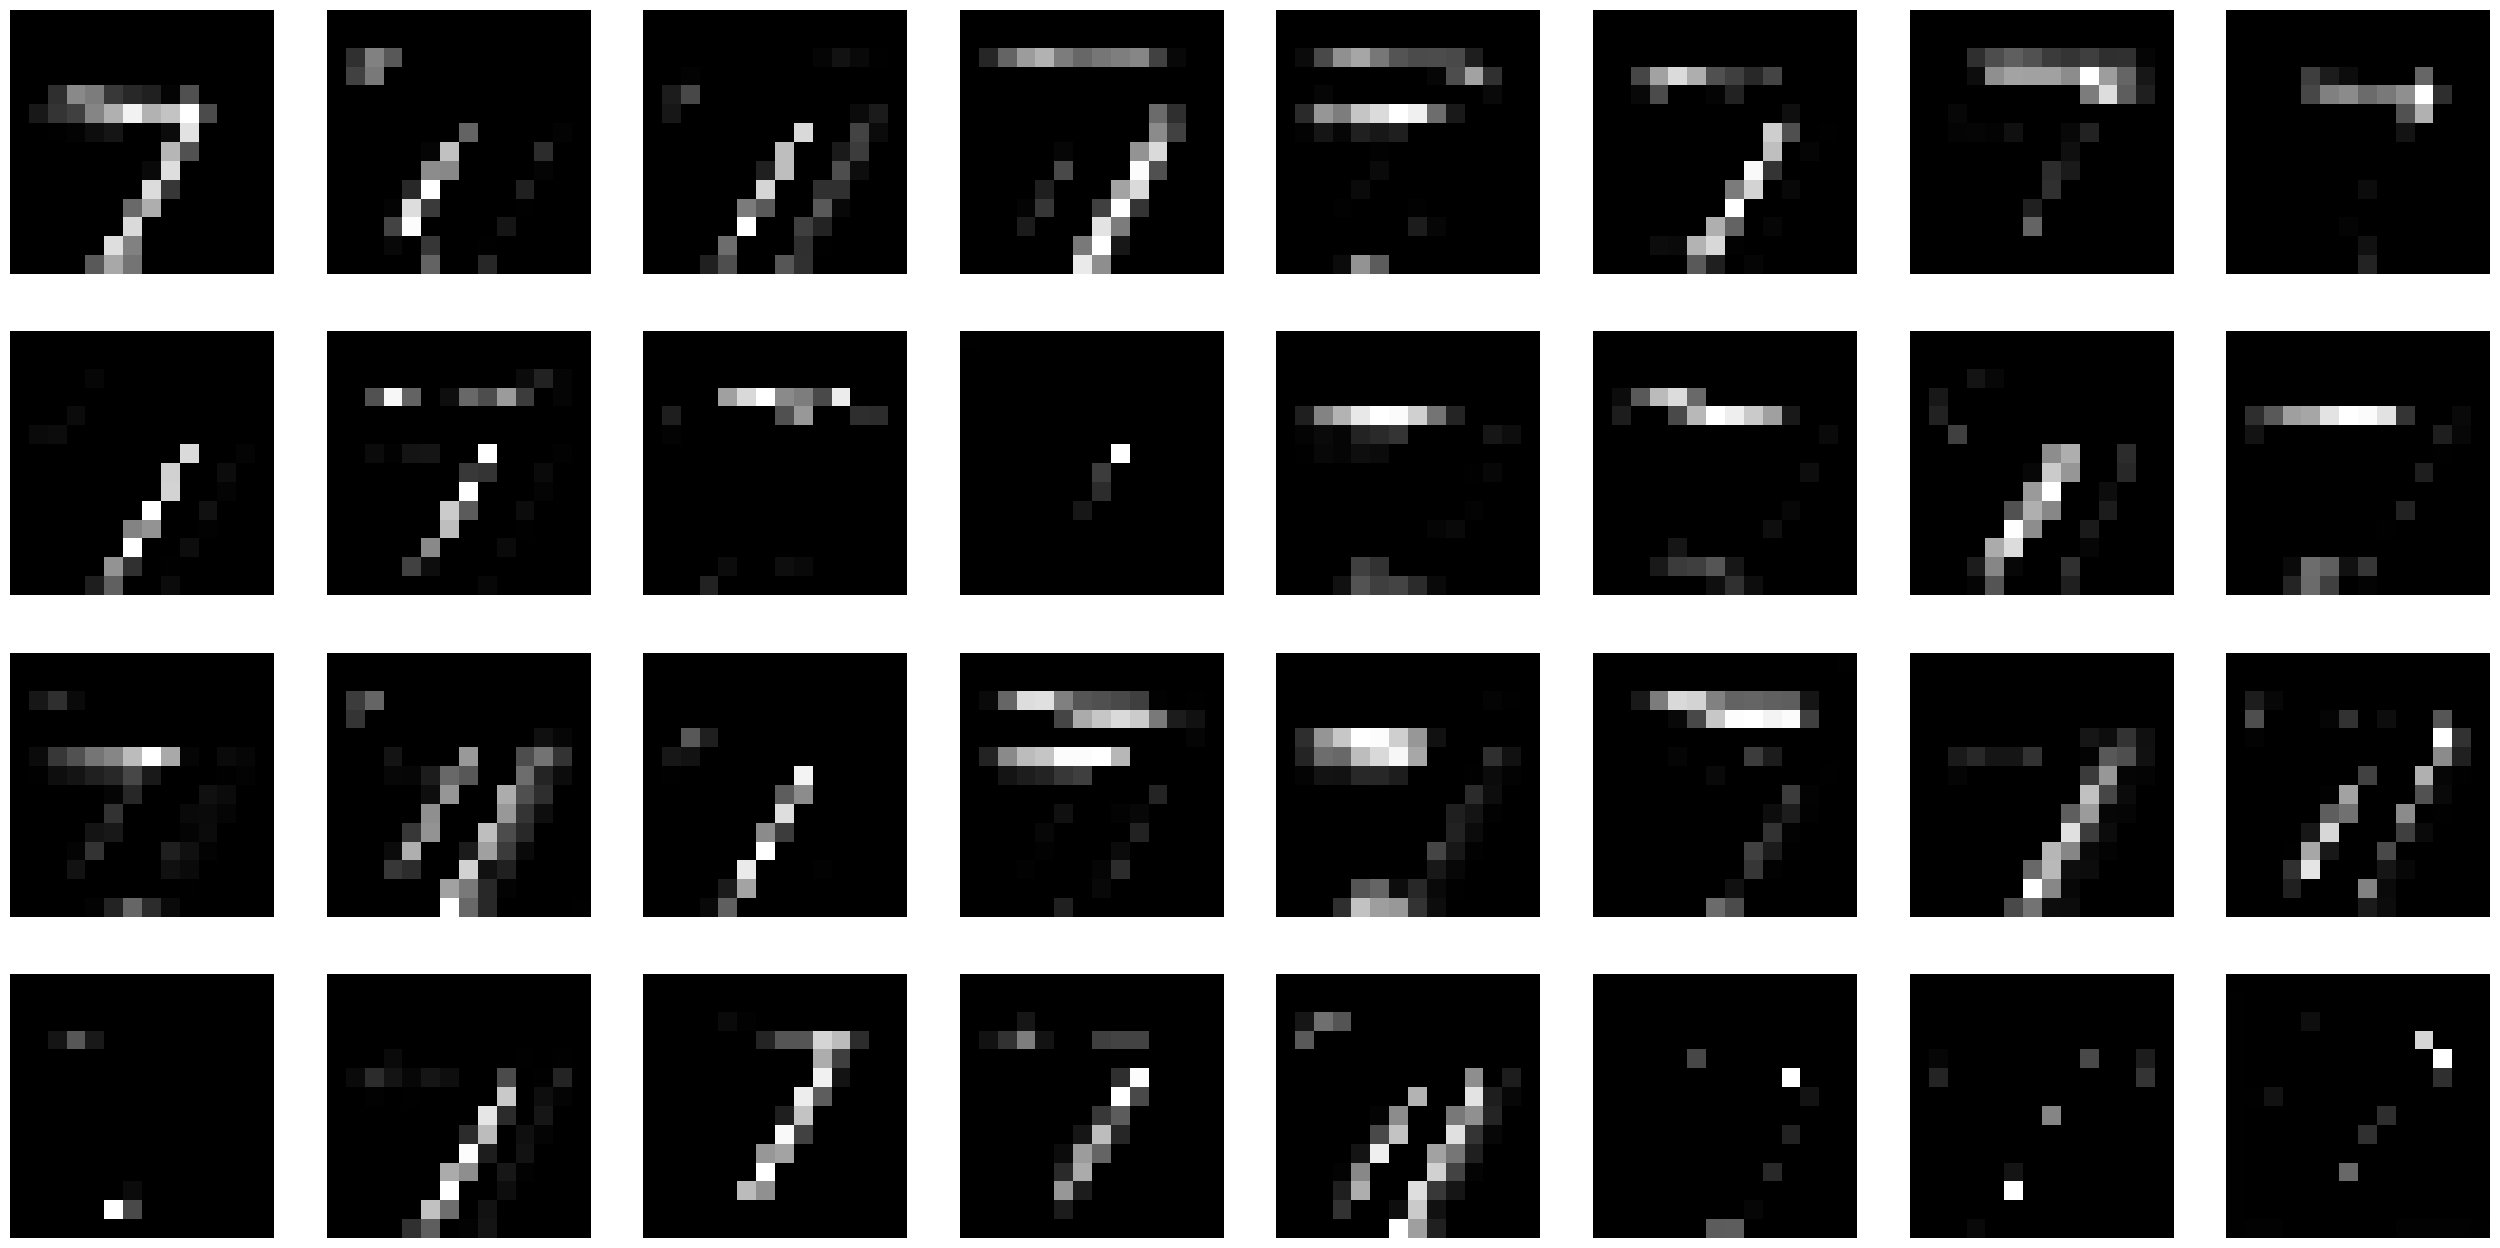

In [43]:
early_layers = cnn.layers[0:4]
part_cnn = tf.keras.models.Sequential(early_layers)
feature_maps2 = part_cnn.predict(X_test[0: 1])

fig, axes = plt.subplots(4, 8, figsize=(32,16))
for index in range(32):
    ax=axes[index // 8][index % 8]
    ax.axis('off')
    ax.imshow(feature_maps2[0, :, :, index], cmap='gray')

### Top convolutional layer

1/1 [==============================] - 0s 60ms/step


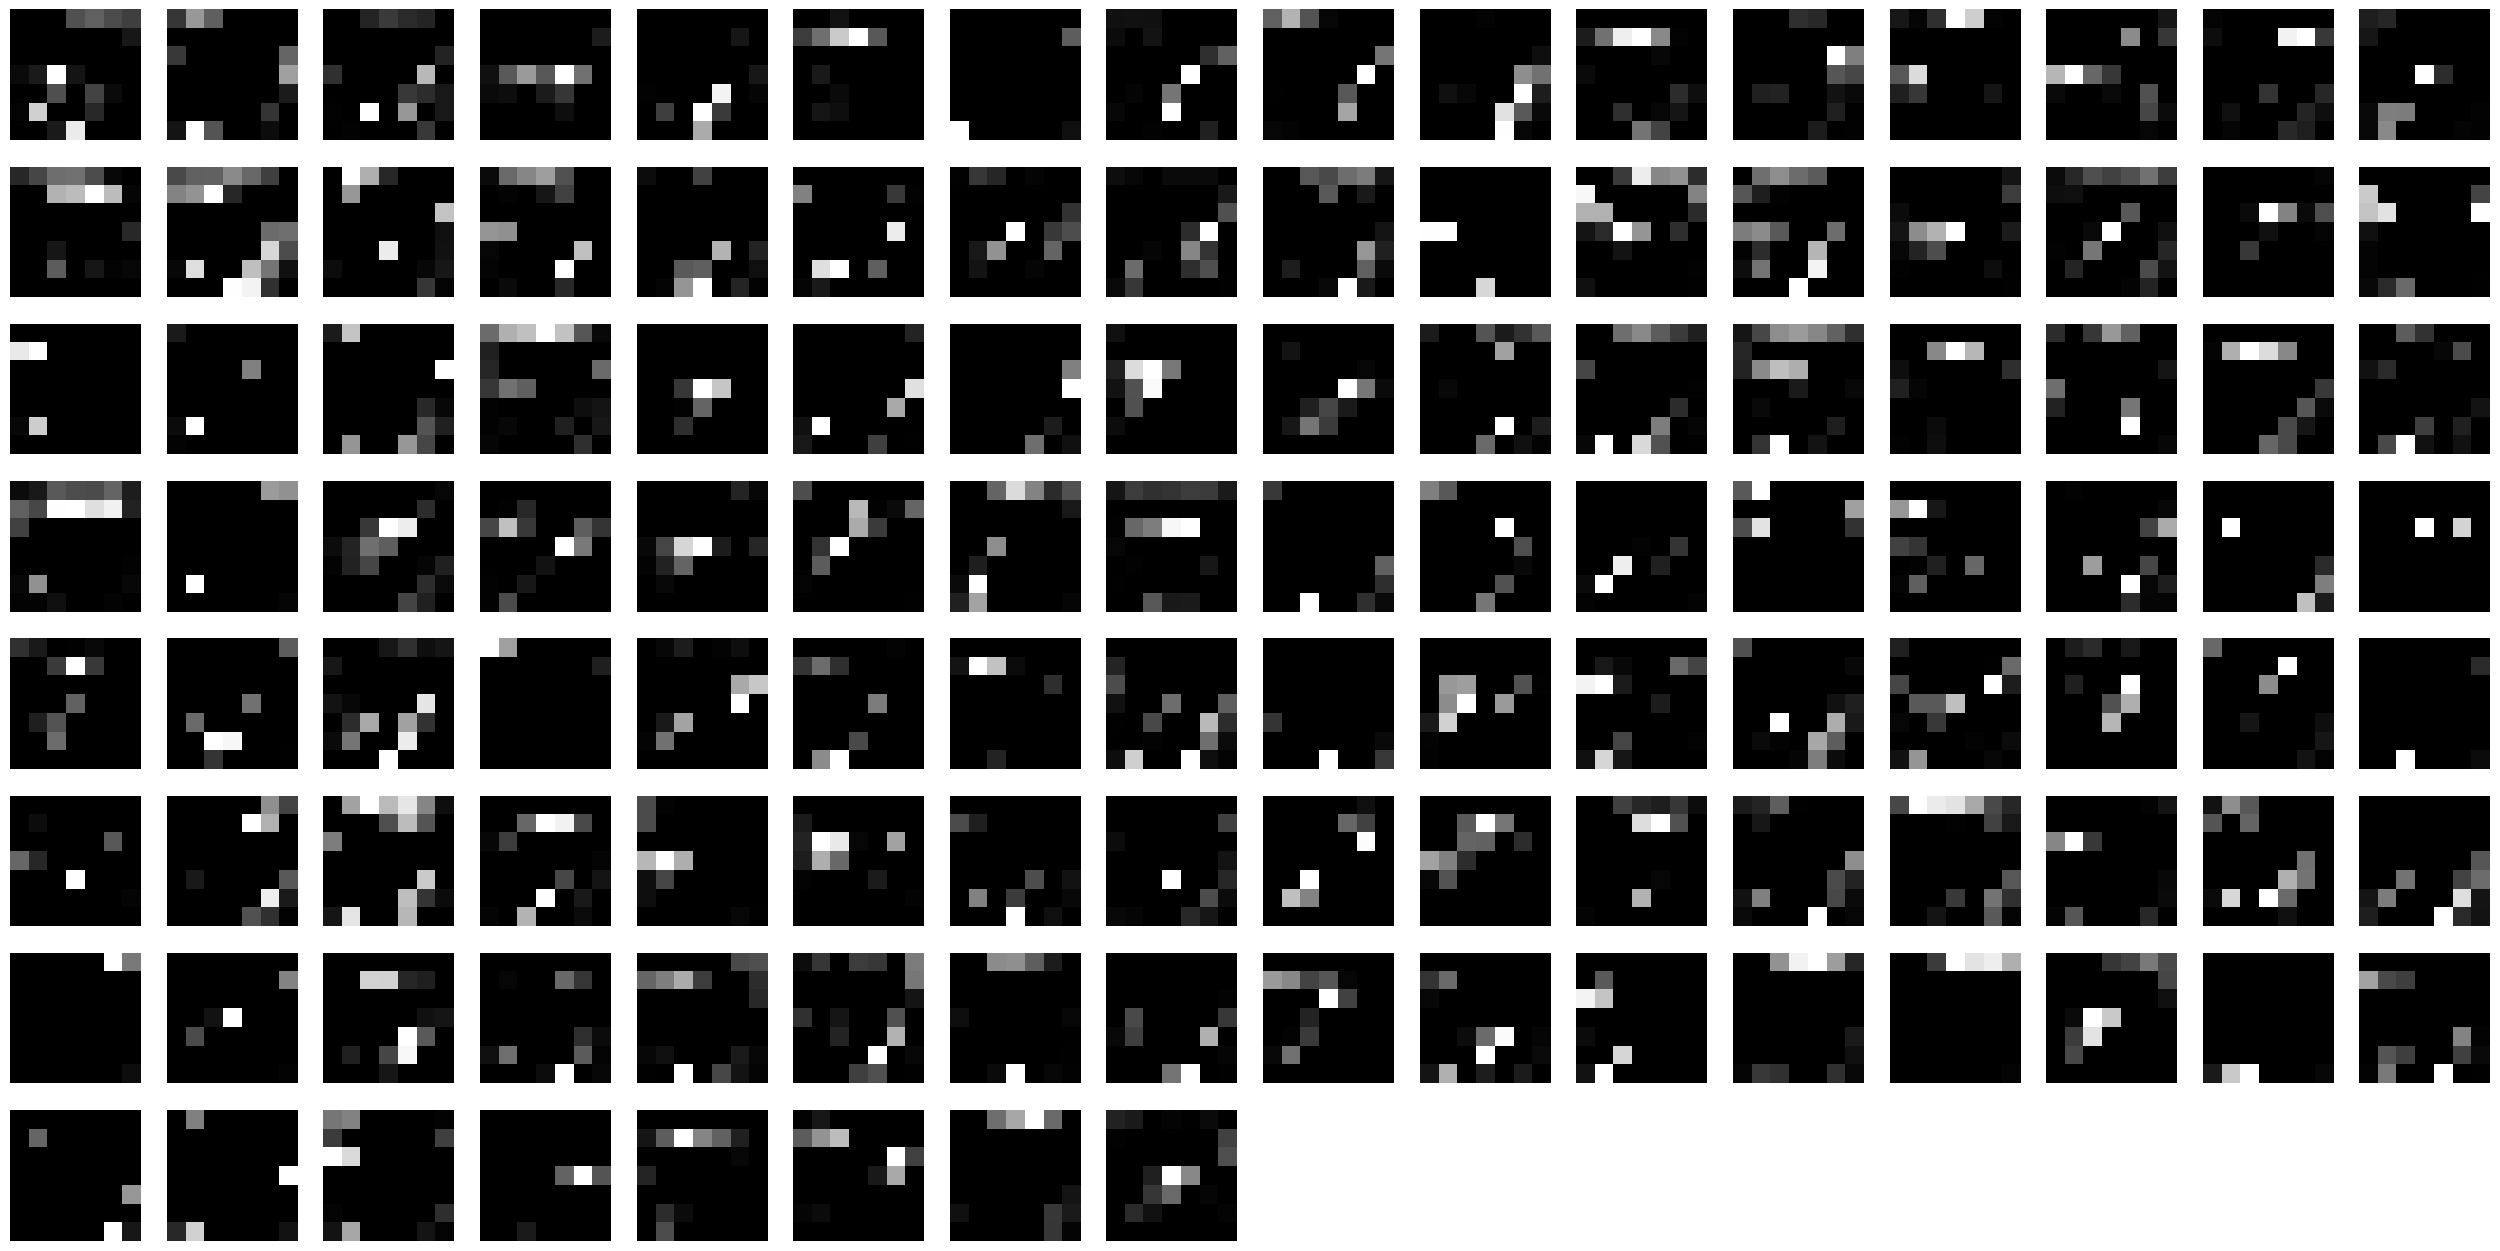

In [46]:
cnn_layers = cnn.layers[0:7]
all_cnn = tf.keras.models.Sequential(cnn_layers)
feature_maps3 = all_cnn.predict(X_test[0: 1])

fig, axes = plt.subplots(8, 16, figsize=(32,16))
for index in range(128):
    ax=axes[index // 16][index % 16]
    ax.axis('off')
    if index < feature_maps3.shape[3]:
        ax.imshow(feature_maps3[0, :, :, index], cmap='gray')

# Consider misclassified digits

313/313 [==============================] - 1s 2ms/step


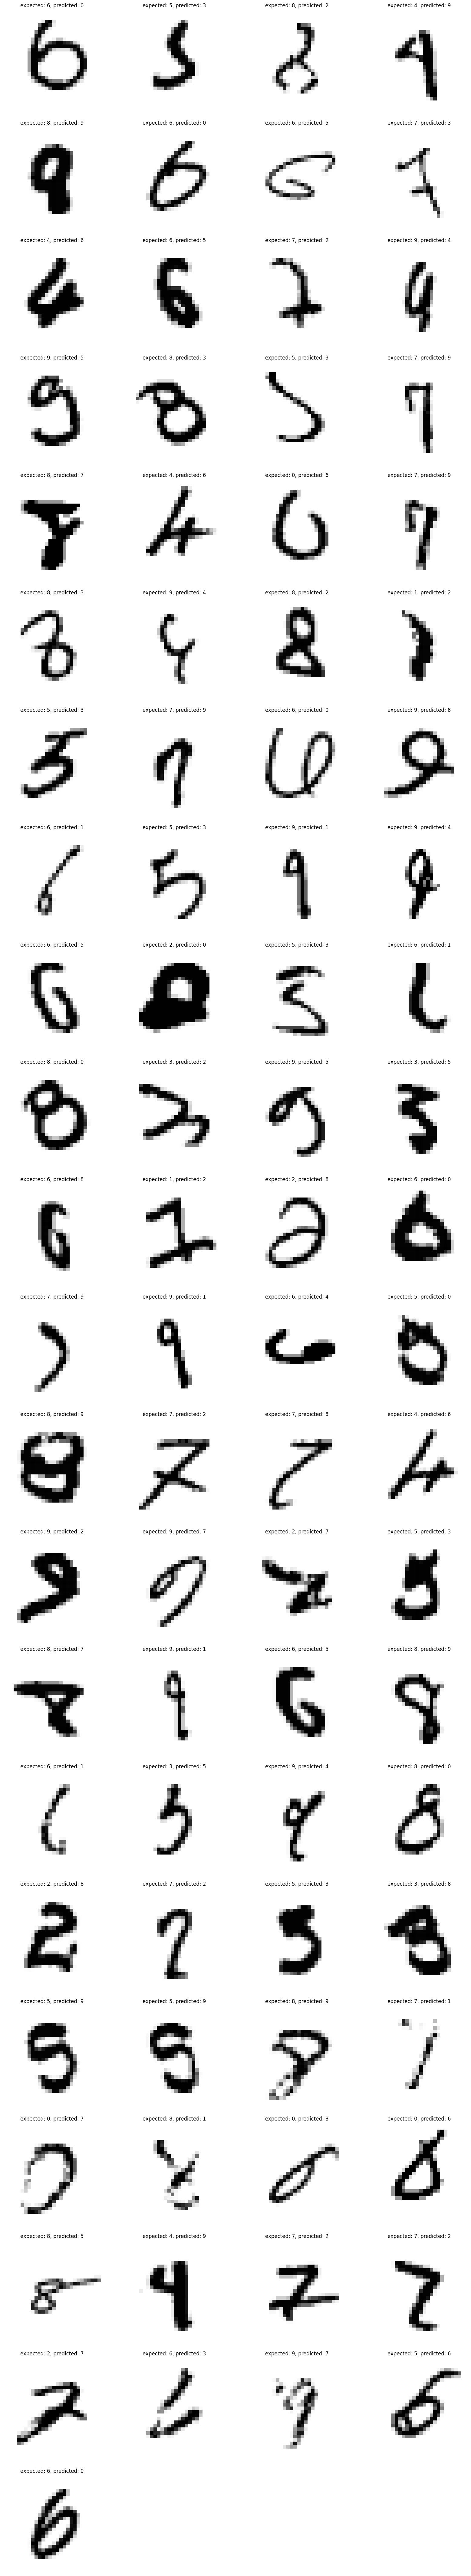

In [47]:
probabilities = np.array(cnn.predict(X_test))
predictions = np.argmax(probabilities, axis = 1) #what does the model predict
labels = np.argmax(y_test, axis = 1) #what are the actual labels
misclas_idxs = np.argwhere(predictions != labels).reshape(-1)

misclas_count = len(misclas_idxs)
ncols = 4
nrows = (misclas_count - 1) // ncols + 1

figure = plt.figure(figsize=(5 * ncols, 5 * nrows))
for i in range(misclas_count):
    idx = misclas_idxs[i]
    ax = figure.add_subplot(nrows, ncols, i + 1, title='expected: {}, predicted: {}'.format(labels[idx], predictions[idx]))
    ax.axis('off')
    ax.imshow(np.reshape(X_test[idx], (28, 28)), cmap='Greys')
